In [13]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import TimeSeriesSplit


#Load & sort
df = pd.read_csv(
    "../data_clean/processed_data_with_features.csv",
    parse_dates=["DATETIME"]
)
df = df.sort_values(["SYMBOL", "DATETIME"]).reset_index(drop=True)

#Encode day‐of‐week as integer 0–6
df["DAY_OF_THE_WEEK"] = df["DATETIME"].dt.dayofweek

#Define feature list + target
FEATURES = [
    "DAY_OF_THE_WEEK", "HOUR_OF_DAY",
    "vol_20",   "vol_60",   "sr_20",      "mean_20",
    "zscore_20","zscore_60",
    "log_momentum_20", "log_momentum_60",
    "bb_upper_20",     "bb_lower_20",     "mdd_20",
    "ema_12", "ema_26", "macd", "macd_signal", "macd_hist"
]
TARGET = "LOG_RETURN"

#Drop only rows missing any of the chosen features or the target
df = df.dropna(subset=FEATURES + [TARGET])

X = df[FEATURES].values
y = df[TARGET].values

tscv = TimeSeriesSplit(n_splits=5)
mse_scores = []
r2_scores = []
dir_accs = []

symbols = df["SYMBOL"].values

all_y_true = []
all_y_pred = []
all_symbols_test = []
all_test_indices = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    symbols_train = symbols[train_idx]
    symbols_test = symbols[test_idx]

    model = GradientBoostingRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=3,
        subsample=0.8,
        max_features=0.8,
        min_samples_split=10,
        min_samples_leaf=5,
        n_iter_no_change=50,
        validation_fraction=0.2,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse_scores.append(mean_squared_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))
    dir_accs.append(np.mean((y_pred > 0) == (y_test > 0)))

    # Collect results for global evaluation
    all_y_true.append(y_test)
    all_y_pred.append(y_pred)
    all_symbols_test.append(symbols_test)
    all_test_indices.append(test_idx)

    print(f"Fold {fold+1}: MSE={mse_scores[-1]:.4f}, R2={r2_scores[-1]:.4f}, DirAcc={dir_accs[-1]:.2%}")

print("\nAverage MSE:", np.mean(mse_scores))
print("Average R2:", np.mean(r2_scores))
print("Average Directional Accuracy:", np.mean(dir_accs))

# After the loop, concatenate all results
y_test_all = np.concatenate(all_y_true)
y_pred_all = np.concatenate(all_y_pred)
symbols_test_all = np.concatenate(all_symbols_test)
test_indices_all = np.concatenate(all_test_indices)




Fold 1: MSE=0.0000, R2=0.1031, DirAcc=57.04%
Fold 2: MSE=0.0000, R2=0.1147, DirAcc=57.46%
Fold 3: MSE=0.0000, R2=0.1016, DirAcc=56.88%
Fold 4: MSE=0.0000, R2=0.1037, DirAcc=56.57%
Fold 5: MSE=0.0000, R2=0.1104, DirAcc=56.89%

Average MSE: 8.670727956748517e-06
Average R2: 0.10671527834978714
Average Directional Accuracy: 0.5696909757125718


Test MSE        : 8.670728e-06
Pearson r       : 0.4378
Dir. Accuracy   : 56.97%

Top 10 stocks by correlation:


,MSE,Corr,Accuracy
PFG,0.000012,0.654702,0.542526
SYF,0.000010,0.612190,0.547680
GS,0.000007,0.605556,0.579897
HBAN,0.000008,0.603308,0.537371
TFC,0.000006,0.591860,0.559278
RF,0.000007,0.591755,0.541237
PRU,0.000006,0.591282,0.588918
USB,0.000005,0.588602,0.556701
CINF,0.000011,0.584934,0.559278
NTRS,0.000008,0.578982,0.568299



Bottom 10 stocks by correlation:


,MSE,Corr,Accuracy
NVR,1.578696e-05,0.299154,0.526316
FE,2.595706e-06,0.295253,0.559278
EQR,4.918738e-06,0.292827,0.570876
VRTX,4.472560e-06,0.291509,0.579897
UDR,4.632233e-06,0.285992,0.567010
TTWO,8.707288e-06,0.272058,0.576031
PODD,2.400102e-05,0.269305,0.574742
SWKS,2.035153e-05,0.265261,0.596649
COR,7.513681e-08,0.237735,0.487179
TPL,1.376587e-04,0.068389,0.500000


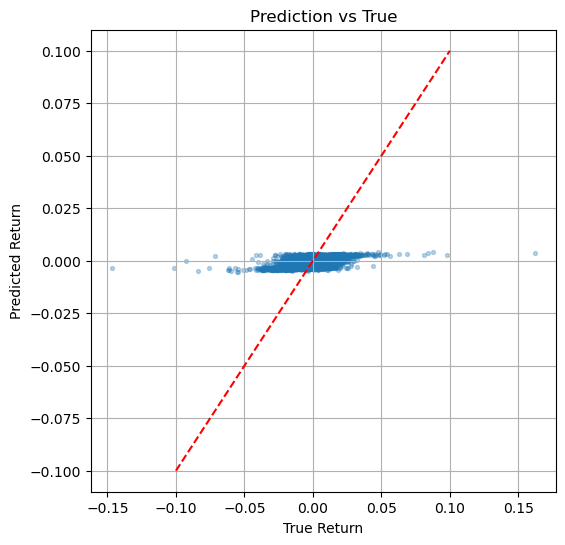

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Overall metrics 
mse_global = mean_squared_error(y_test_all, y_pred_all)
corr_global = np.corrcoef(y_pred_all, y_test_all)[0, 1]
dir_acc = np.mean((y_pred_all > 0) == (y_test_all > 0))

print(f"Test MSE        : {mse_global:.6e}")
print(f"Pearson r       : {corr_global:.4f}")
print(f"Dir. Accuracy   : {dir_acc:.2%}")

# 2) Per-ticker metrics
mse_by_stock, corr_by_stock, acc_by_stock = {}, {}, {}

for sym in np.unique(symbols_test_all):
    mask = (symbols_test_all == sym)
    yt = y_test_all[mask]
    yp = y_pred_all[mask]
    if len(yt) < 5:
        continue  # skip tiny samples

    mse_by_stock[sym]  = mean_squared_error(yt, yp)
    corr_by_stock[sym] = (
        np.corrcoef(yt, yp)[0,1] if np.std(yt) > 0 else np.nan
    )
    acc_by_stock[sym]  = np.mean((yp > 0) == (yt > 0))

results_df = pd.DataFrame({
    "MSE":    mse_by_stock,
    "Corr":   corr_by_stock,
    "Accuracy": acc_by_stock
}).sort_values("Corr", ascending=False)

print("\nTop 10 stocks by correlation:")
display(results_df.head(10))

print("\nBottom 10 stocks by correlation:")
display(results_df.tail(10))

# 3) Scatter plot
plt.figure(figsize=(6,6))
plt.scatter(y_test_all, y_pred_all, alpha=0.3, s=8)
plt.plot([-0.1, 0.1], [-0.1, 0.1], 'r--')
plt.xlabel("True Return")
plt.ylabel("Predicted Return")
plt.title("Prediction vs True")
plt.grid(True)
plt.show()

C:\Users\AndrewA\AppData\Local\Temp\ipykernel_10704\2159670259.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(bar_log_return)


Test period covers 21 days: [datetime.date(2021, 12, 2) datetime.date(2021, 12, 3)
 datetime.date(2021, 12, 6) datetime.date(2021, 12, 7)
 datetime.date(2021, 12, 8) datetime.date(2021, 12, 9)
 datetime.date(2021, 12, 10) datetime.date(2021, 12, 13)
 datetime.date(2021, 12, 14) datetime.date(2021, 12, 15)
 datetime.date(2021, 12, 16) datetime.date(2021, 12, 17)
 datetime.date(2021, 12, 20) datetime.date(2021, 12, 21)
 datetime.date(2021, 12, 22) datetime.date(2021, 12, 23)
 datetime.date(2021, 12, 27) datetime.date(2021, 12, 28)
 datetime.date(2021, 12, 29) datetime.date(2021, 12, 30)
 datetime.date(2021, 12, 31)]

Daily Sharpe: insufficient variation (std=0) → cannot compute.

Max Drawdown    : -0.75%
Intraday Sharpe : 36.15


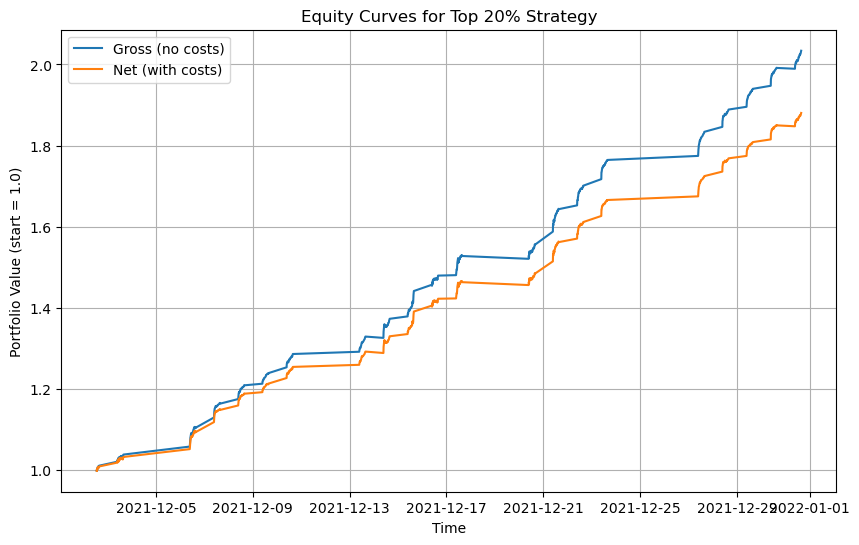

In [17]:
# Rebuild the test DataFrame with all test results from all folds
test_df = pd.DataFrame({
    "DATETIME":   df.iloc[test_indices_all]["DATETIME"].values,
    "SYMBOL":     df.iloc[test_indices_all]["SYMBOL"].values,
    "y_pred":     y_pred_all,
    "LOG_RETURN": y_test_all
}).sort_values("DATETIME")

# Determine the 80th percentile of predicted returns at each bar,
# then go long (signal=1) on those at or above that threshold
quantile = 0.20
thresholds = (
    test_df
      .groupby("DATETIME")["y_pred"]
      .transform(lambda x: x.quantile(1 - quantile))
)
test_df["signal"] = (test_df["y_pred"] >= thresholds).astype(int)

def bar_log_return(grp):
    longs = grp.loc[grp["signal"] == 1, "LOG_RETURN"]
    return longs.mean() if len(longs) else 0.0

portf = (
    test_df
      .groupby("DATETIME")
      .apply(bar_log_return)
      .rename("portfolio_logret")
)

signals_wide = test_df.pivot(index="DATETIME", columns="SYMBOL", values="signal").fillna(0)
turnover     = signals_wide.diff().abs().sum(axis=1) / signals_wide.shape[1]

tc_rate   = 0.001
portf_net = portf - turnover * tc_rate

cum_gross = np.exp(portf.cumsum())
cum_net   = np.exp(portf_net.cumsum())

n_days          = test_df["DATETIME"].dt.date.nunique()
bars_per_day    = len(portf_net) / n_days
ann_factor      = np.sqrt(252 * bars_per_day)
sharpe_intraday = (portf_net.mean() / portf_net.std()) * ann_factor

test_dates = test_df["DATETIME"].dt.date.unique()
print(f"Test period covers {len(test_dates)} days: {test_dates}\n")

daily_logret = portf_net.groupby(test_df["DATETIME"].dt.date).sum()

if daily_logret.std() == 0 or len(daily_logret) < 2:
    print("Daily Sharpe: insufficient variation (std=0) → cannot compute.\n")
else:
    daily_sharpe = (daily_logret.mean() / daily_logret.std()) * np.sqrt(252)
    print(f"Daily Sharpe Ratio : {daily_sharpe:.2f}\n")

running_max = cum_net.cummax()
max_drawdown = (cum_net / running_max - 1).min()

print(f"Max Drawdown    : {max_drawdown:.2%}")
print(f"Intraday Sharpe : {sharpe_intraday:.2f}")

plt.figure(figsize=(10,6))
plt.plot(cum_gross, label="Gross (no costs)")
plt.plot(cum_net,   label="Net (with costs)")
plt.title("Equity Curves for Top 20% Strategy")
plt.xlabel("Time")
plt.ylabel("Portfolio Value (start = 1.0)")
plt.legend()
plt.grid(True)
plt.show()
